# 📘 04 — Model Selection

## 🧭 Tabla de Contenido
1. [Setup y Carga de Datos](#sec1)
2. [Preparación de Datos para Modelos](#sec2)
   - [División Train/Validation/Test](#sec2_1)
   - [Pipeline de Preprocesamiento](#sec2_2)
3. [Definición de Modelos Base](#sec3)
   - **[Configuración de Hiperparámetros](#sec3_1)**
4. [Estrategia de Validación](#sec4)
5. [Entrenamiento de Modelos Base](#sec5)
6. [Comparación de Modelos](#sec6)
7. [Curvas de Aprendizaje](#sec7)
8. [Análisis de Predicciones](#sec8)
9. [Selección de Mejores Modelos](#sec9)
10. [Resumen Ejecutivo](#sec10)

# 1. Setup y Carga de Datos <a id='sec1'></a>

Configuramos el entorno y cargamos el dataset procesado del notebook anterior.

In [1]:
# Importar librerías esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import joblib
from datetime import datetime
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Librerías importadas correctamente")
print(f"📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Librerías importadas correctamente
📅 Fecha de ejecución: 2025-11-25 23:18:46


In [2]:
print("="*80)
print("CARGA DE DATOS")
print("="*80)

# Cargar dataset con features
df = pd.read_csv('../data/processed/coffee_features.csv')

print(f"\n📊 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"\n📋 Primeras filas:")
display(df.head())

print(f"\n🔍 Información del dataset:")
print(df.info())

# Verificar integridad
null_count = df.isnull().sum().sum()
inf_count = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()

print(f"\n✅ Verificación de integridad:")
print(f"  • Valores nulos: {null_count}")
print(f"  • Valores infinitos: {inf_count}")

if null_count == 0 and inf_count == 0:
    print("  ✅ Dataset limpio y listo para modelado")
else:
    print("  ⚠️  Se requiere limpieza adicional")

CARGA DE DATOS

📊 Dimensiones: 1234 filas × 39 columnas

📋 Primeras filas:


,Number.of.Bags,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Moisture,Category.One.Defects,Quakers,Category.Two.Defects,altitude_mean_meters,Processing.Method_natural dry,Processing.Method_other,Processing.Method_pulped natural honey,Processing.Method_semiwashed semipulped,Processing.Method_washed wet,Country.of.Origin_freq,In.Country.Partner_freq,Variety_freq,Certification.Body_freq,Owner_target_enc,altitude_mean_meters_log,Category.One.Defects_log,Category.Two.Defects_log,Balance_Ratio,Flavor_Aroma_Interaction,Mouthfeel_Score,Sensory_Score,High_Altitude,Has_Defects,Optimal_Moisture,Flavor_Squared,Aroma_Squared,Total.Cup.Points
0,1.0996,2.9240,3.2927,3.1659,3.2200,2.7084,2.2124,0.2822,0.2079,0.2210,2.6423,0.6246,-0.2147,-0.2110,-0.6661,0.0457,-0.4914,-0.1467,-0.1071,-0.2180,0.7497,-1.1009,-1.5061,-0.4769,-1.5045,3.9079,0.6985,-0.3458,-1.2381,0.0686,9.6277,2.9372,20.8767,0,0,0,10.8416,8.5497,90.5800
1,1.0996,3.1349,2.8928,2.7459,2.7729,2.4902,2.2124,0.2822,0.2079,0.2210,2.2855,0.6246,-0.2147,-0.2110,-0.4797,0.0457,-0.4914,-0.1467,-0.1071,-0.2180,0.7497,-1.1009,-1.5061,-0.4769,-1.5045,3.9079,0.6985,-0.3458,-0.4554,0.0797,9.0686,2.6180,19.2455,0,0,0,8.3682,9.8277,89.9200
2,1.2541,1.6057,2.6679,2.5482,2.3520,2.7084,1.8010,0.2822,0.2079,0.2210,2.4744,0.4053,-0.2147,-0.2110,-0.2933,0.0366,2.0351,-0.1467,-0.1071,-0.2180,-1.3339,-1.1009,-1.5061,-0.4769,-1.5045,3.5155,0.6560,-0.3458,0.0025,0.0939,4.2839,2.6283,16.8686,0,0,0,7.1175,2.5784,89.0000
3,1.0996,1.8167,2.4679,2.1281,2.5624,2.4902,1.9946,0.2822,0.2079,0.2210,2.2855,0.6246,-0.2147,-0.2110,-0.2933,0.0457,-0.4914,-0.1467,-0.1071,-0.2180,0.7497,-1.1009,-1.5061,-0.4769,-1.5045,3.9079,0.6985,-0.3458,0.0025,0.0862,4.4834,2.3092,16.4564,0,0,0,6.0907,3.3002,88.8300
4,-0.4456,2.2649,2.4679,2.3258,2.5624,2.0265,1.8010,0.2822,0.2079,0.2210,2.1176,0.4053,-0.2147,-0.2110,-0.6661,-0.0486,-0.4914,-0.1467,-0.1071,-0.2180,0.7497,-1.4485,-1.5305,-0.4769,-1.5290,3.3891,0.1588,-0.3458,-1.2381,0.0862,5.5895,2.1762,16.2772,0,0,0,6.0907,5.1296,88.7500



🔍 Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Number.of.Bags                           1234 non-null   float64
 1   Aroma                                    1234 non-null   float64
 2   Flavor                                   1234 non-null   float64
 3   Aftertaste                               1234 non-null   float64
 4   Acidity                                  1234 non-null   float64
 5   Body                                     1234 non-null   float64
 6   Balance                                  1234 non-null   float64
 7   Uniformity                               1234 non-null   float64
 8   Clean.Cup                                1234 non-null   float64
 9   Sweetness                                1234 non-null   float64
 10  Cupper.Points       

# 2. Preparación de Datos para Modelos <a id='sec2'></a>

Separamos datos y preparamos pipelines para evitar data leakage.

## 2.1 División Train/Validation/Test <a id='sec2_1'></a>

Estrategia de división:
- **Train**: 70% - Para entrenar modelos
- **Validation**: 15% - Para comparar modelos y ajustar hiperparámetros
- **Test**: 15% - Para evaluación final (no se toca hasta el final)

DIVISIÓN DE DATOS

📊 Dataset completo:
  • Features (X): (1234, 38)
  • Target (y): (1234,)
  • Columnas: 38 features

📊 División de datos:
  • Train: 863 muestras (69.9%)
  • Validation: 185 muestras (15.0%)
  • Test: 186 muestras (15.1%)

📈 Distribución del target:

  Train:
    Media: 81.98
    Std: 3.96
    Rango: [0.00, 90.58]

  Validation:
    Media: 82.24
    Std: 2.28
    Rango: [67.92, 88.83]

  Test:
    Media: 82.14
    Std: 2.36
    Rango: [71.75, 88.67]


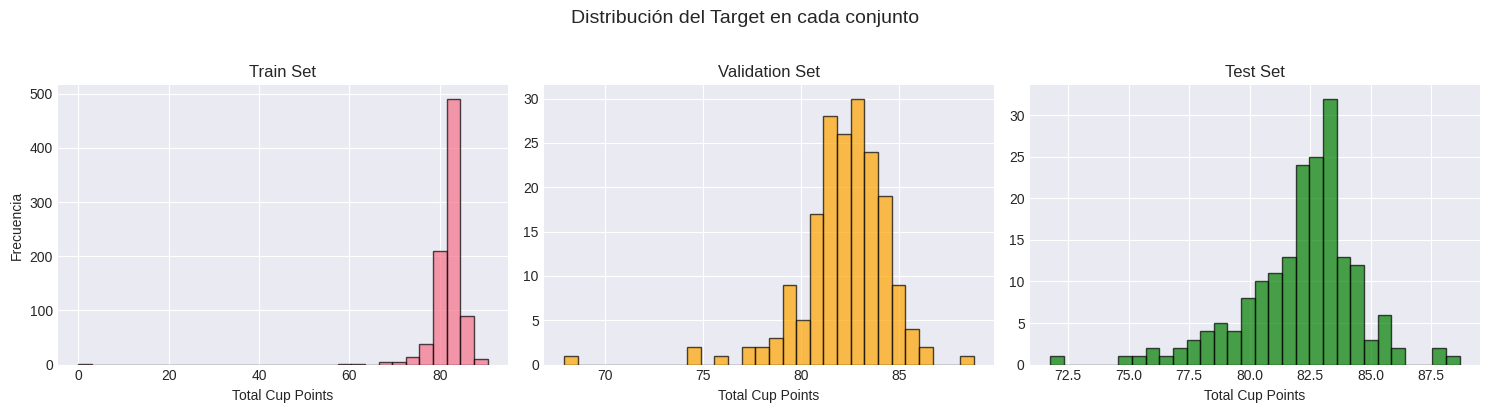


✅ División completada exitosamente


In [3]:
from sklearn.model_selection import train_test_split

print("="*80)
print("DIVISIÓN DE DATOS")
print("="*80)

# Identificar target
target_column = 'Total.Cup.Points'

# Separar features y target
X = df.drop(columns=[target_column])
y = df[target_column]

print(f"\n📊 Dataset completo:")
print(f"  • Features (X): {X.shape}")
print(f"  • Target (y): {y.shape}")
print(f"  • Columnas: {X.shape[1]} features")

# Primera división: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, shuffle=True
)

# Segunda división: 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, shuffle=True
)

print(f"\n📊 División de datos:")
print(f"  • Train: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  • Validation: {X_val.shape[0]} muestras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  • Test: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verificar distribución del target
print(f"\n📈 Distribución del target:")
print(f"\n  Train:")
print(f"    Media: {y_train.mean():.2f}")
print(f"    Std: {y_train.std():.2f}")
print(f"    Rango: [{y_train.min():.2f}, {y_train.max():.2f}]")

print(f"\n  Validation:")
print(f"    Media: {y_val.mean():.2f}")
print(f"    Std: {y_val.std():.2f}")
print(f"    Rango: [{y_val.min():.2f}, {y_val.max():.2f}]")

print(f"\n  Test:")
print(f"    Media: {y_test.mean():.2f}")
print(f"    Std: {y_test.std():.2f}")
print(f"    Rango: [{y_test.min():.2f}, {y_test.max():.2f}]")

# Visualizar distribuciones
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(y_train, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Train Set')
axes[0].set_xlabel('Total Cup Points')
axes[0].set_ylabel('Frecuencia')

axes[1].hist(y_val, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Validation Set')
axes[1].set_xlabel('Total Cup Points')

axes[2].hist(y_test, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[2].set_title('Test Set')
axes[2].set_xlabel('Total Cup Points')

plt.suptitle('Distribución del Target en cada conjunto', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

print("\n✅ División completada exitosamente")

## 2.2 Verificación de Escalado <a id='sec2_2'></a>

Las features ya fueron escaladas en el notebook 03, pero verificamos su estado.

In [4]:
print("="*80)
print("VERIFICACIÓN DE ESCALADO")
print("="*80)

# Verificar si las features están escaladas
print(f"\n📊 Estadísticas de features (primeras 10):")
print(X_train.iloc[:, :10].describe())

# Calcular media y std para verificar escalado
means = X_train.mean()
stds = X_train.std()

# Features con media cercana a 0 y std cercana a 1 están escaladas
scaled_features = ((means.abs() < 0.5) & (stds > 0.5) & (stds < 2.0)).sum()
total_features = len(means)

print(f"\n📈 Análisis de escalado:")
print(f"  • Features aparentemente escaladas: {scaled_features}/{total_features}")
print(f"  • Porcentaje: {scaled_features/total_features*100:.1f}%")

if scaled_features / total_features > 0.7:
    print("\n✅ La mayoría de features están escaladas")
    print("   No se requiere escalado adicional")
else:
    print("\n⚠️  Algunas features podrían no estar escaladas")
    print("   Considerar aplicar StandardScaler si es necesario")

VERIFICACIÓN DE ESCALADO

📊 Estadísticas de features (primeras 10):
       Number.of.Bags    Aroma   Flavor  Aftertaste  Acidity     Body  \
count        863.0000 863.0000 863.0000    863.0000 863.0000 863.0000   
mean          -0.0098  -0.0166  -0.0024     -0.0020   0.0036  -0.0074   
std            1.0119   1.0646   1.0665      1.0582   1.0883   1.0867   
min           -1.2182 -19.9346 -18.7751    -18.2580 -19.7966 -20.4768   
25%           -1.1023  -0.6089  -0.4561     -0.5406  -0.5152  -0.4829   
50%            0.3270   0.0502  -0.0312      0.0771  -0.0680  -0.0192   
75%            0.9065   0.4984   0.5935      0.4725   0.5896   0.4445   
max            6.9869   3.1349   3.2927      3.1659   3.2200   2.7084   

       Balance  Uniformity  Clean.Cup  Sweetness  
count 863.0000    863.0000   863.0000   863.0000  
mean   -0.0073     -0.0385    -0.0388    -0.0055  
std     1.0796      1.1061     1.1325     1.0724  
min   -18.1606    -17.8615   -12.6139   -16.5807  
25%    -0.4250     

# 3. Definición de Modelos Base <a id='sec3'></a>

Evaluamos modelos de diferentes familias para identificar los más prometedores:
- **Modelos lineales**: LinearRegression, Ridge, Lasso, ElasticNet
- **Modelos basados en distancia**: KNN
- **Árboles**: DecisionTree
- **Ensembles**: RandomForest, GradientBoosting, XGBoost
- **Otros**: SVR, MLP

In [5]:
# Importar modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor
)
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Intentar importar XGBoost (opcional)
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️  XGBoost no disponible (pip install xgboost)")

print("✅ Modelos importados correctamente")

✅ Modelos importados correctamente


In [6]:
print("="*80)
print("DEFINICIÓN DE MODELOS BASE")
print("="*80)

# Diccionario de modelos con configuración base
models = {
    # Modelos lineales
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'Lasso': Lasso(alpha=0.01, random_state=RANDOM_STATE, max_iter=5000),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=5000),
    
    # Modelos basados en distancia
    'KNN': KNeighborsRegressor(n_neighbors=5),
    
    # Árboles
    'DecisionTree': DecisionTreeRegressor(max_depth=10, random_state=RANDOM_STATE),
    
    # Ensembles
    'RandomForest': RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'ExtraTrees': ExtraTreesRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=RANDOM_STATE
    ),
    'AdaBoost': AdaBoostRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=RANDOM_STATE
    ),
    
    # SVM
    'SVR': SVR(kernel='rbf', C=10.0, epsilon=0.1),
    
    # Neural Networks
    'MLP': MLPRegressor(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        max_iter=500,
        early_stopping=True,
        random_state=RANDOM_STATE
    )
}

# Agregar XGBoost si está disponible
if XGBOOST_AVAILABLE:
    models['XGBoost'] = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

print(f"\n📊 Total de modelos definidos: {len(models)}")
print("\n📋 Lista de modelos:")
for i, name in enumerate(models.keys(), 1):
    print(f"  {i:2d}. {name}")

print("\n✅ Modelos configurados correctamente")

DEFINICIÓN DE MODELOS BASE

📊 Total de modelos definidos: 13

📋 Lista de modelos:
   1. LinearRegression
   2. Ridge
   3. Lasso
   4. ElasticNet
   5. KNN
   6. DecisionTree
   7. RandomForest
   8. ExtraTrees
   9. GradientBoosting
  10. AdaBoost
  11. SVR
  12. MLP
  13. XGBoost

✅ Modelos configurados correctamente


## 3.1 Configuración de Hiperparámetros <a id='sec3_1'></a>

A continuación se presenta la tabla detallada de hiperparámetros evaluados para cada modelo. En esta fase de evaluación inicial, se utilizaron configuraciones base con valores fijos para identificar los modelos más prometedores.



In [7]:
print("="*80)
print("TABLA DE HIPERPARÁMETROS EVALUADOS")
print("="*80)

# Definir tabla de hiperparámetros
hyperparams_data = []

# LinearRegression
hyperparams_data.append({
    'Modelo': 'LinearRegression',
    'Hiperparámetro': 'fit_intercept',
    'Valor Usado': 'True',
    'Rango Sugerido': '[True, False]',
    'Descripción': 'Si calcular el intercepto (término independiente)'
})
hyperparams_data.append({
    'Modelo': 'LinearRegression',
    'Hiperparámetro': 'Regularización',
    'Valor Usado': 'None',
    'Rango Sugerido': 'N/A',
    'Descripción': 'Sin regularización (modelo base)'
})

# Ridge
hyperparams_data.append({
    'Modelo': 'Ridge',
    'Hiperparámetro': 'alpha',
    'Valor Usado': '1.0',
    'Rango Sugerido': '[0.001, 0.01, 0.1, 1, 10, 100]',
    'Descripción': 'Fuerza de regularización L2'
})
hyperparams_data.append({
    'Modelo': 'Ridge',
    'Hiperparámetro': 'solver',
    'Valor Usado': 'auto',
    'Rango Sugerido': '[auto, svd, cholesky, lsqr]',
    'Descripción': 'Algoritmo de optimización'
})

# Lasso
hyperparams_data.append({
    'Modelo': 'Lasso',
    'Hiperparámetro': 'alpha',
    'Valor Usado': '0.01',
    'Rango Sugerido': '[0.0001, 0.001, 0.01, 0.1, 1]',
    'Descripción': 'Fuerza de regularización L1 (feature selection)'
})
hyperparams_data.append({
    'Modelo': 'Lasso',
    'Hiperparámetro': 'max_iter',
    'Valor Usado': '5000',
    'Rango Sugerido': '[1000, 5000, 10000]',
    'Descripción': 'Máximo número de iteraciones para convergencia'
})

# ElasticNet
hyperparams_data.append({
    'Modelo': 'ElasticNet',
    'Hiperparámetro': 'alpha',
    'Valor Usado': '0.01',
    'Rango Sugerido': '[0.0001, 0.001, 0.01, 0.1, 1]',
    'Descripción': 'Fuerza de regularización combinada L1+L2'
})
hyperparams_data.append({
    'Modelo': 'ElasticNet',
    'Hiperparámetro': 'l1_ratio',
    'Valor Usado': '0.5',
    'Rango Sugerido': '[0.1, 0.3, 0.5, 0.7, 0.9]',
    'Descripción': 'Balance L1/L2 (0=Ridge, 1=Lasso)'
})
hyperparams_data.append({
    'Modelo': 'ElasticNet',
    'Hiperparámetro': 'max_iter',
    'Valor Usado': '5000',
    'Rango Sugerido': '[1000, 5000, 10000]',
    'Descripción': 'Máximo número de iteraciones'
})

# KNN
hyperparams_data.append({
    'Modelo': 'KNN',
    'Hiperparámetro': 'n_neighbors',
    'Valor Usado': '5',
    'Rango Sugerido': '[3, 5, 7, 10, 15, 20]',
    'Descripción': 'Número de vecinos más cercanos'
})
hyperparams_data.append({
    'Modelo': 'KNN',
    'Hiperparámetro': 'weights',
    'Valor Usado': 'uniform',
    'Rango Sugerido': '[uniform, distance]',
    'Descripción': 'Función de peso (uniforme o por distancia)'
})
hyperparams_data.append({
    'Modelo': 'KNN',
    'Hiperparámetro': 'metric',
    'Valor Usado': 'minkowski',
    'Rango Sugerido': '[minkowski, euclidean, manhattan]',
    'Descripción': 'Métrica de distancia'
})

# DecisionTree
hyperparams_data.append({
    'Modelo': 'DecisionTree',
    'Hiperparámetro': 'max_depth',
    'Valor Usado': '10',
    'Rango Sugerido': '[5, 10, 15, 20, None]',
    'Descripción': 'Profundidad máxima del árbol'
})
hyperparams_data.append({
    'Modelo': 'DecisionTree',
    'Hiperparámetro': 'min_samples_split',
    'Valor Usado': '2',
    'Rango Sugerido': '[2, 5, 10, 20]',
    'Descripción': 'Muestras mínimas para dividir nodo'
})
hyperparams_data.append({
    'Modelo': 'DecisionTree',
    'Hiperparámetro': 'min_samples_leaf',
    'Valor Usado': '1',
    'Rango Sugerido': '[1, 2, 5, 10]',
    'Descripción': 'Muestras mínimas en hoja'
})

# RandomForest
hyperparams_data.append({
    'Modelo': 'RandomForest',
    'Hiperparámetro': 'n_estimators',
    'Valor Usado': '100',
    'Rango Sugerido': '[50, 100, 200, 300, 500]',
    'Descripción': 'Número de árboles en el bosque'
})
hyperparams_data.append({
    'Modelo': 'RandomForest',
    'Hiperparámetro': 'max_depth',
    'Valor Usado': '15',
    'Rango Sugerido': '[10, 15, 20, 30, None]',
    'Descripción': 'Profundidad máxima de cada árbol'
})
hyperparams_data.append({
    'Modelo': 'RandomForest',
    'Hiperparámetro': 'min_samples_split',
    'Valor Usado': '5',
    'Rango Sugerido': '[2, 5, 10, 20]',
    'Descripción': 'Muestras mínimas para dividir nodo'
})
hyperparams_data.append({
    'Modelo': 'RandomForest',
    'Hiperparámetro': 'max_features',
    'Valor Usado': 'sqrt',
    'Rango Sugerido': '[sqrt, log2, None, 0.5]',
    'Descripción': 'Número de features para mejor split'
})

# ExtraTrees
hyperparams_data.append({
    'Modelo': 'ExtraTrees',
    'Hiperparámetro': 'n_estimators',
    'Valor Usado': '100',
    'Rango Sugerido': '[50, 100, 200, 300, 500]',
    'Descripción': 'Número de árboles extremadamente aleatorios'
})
hyperparams_data.append({
    'Modelo': 'ExtraTrees',
    'Hiperparámetro': 'max_depth',
    'Valor Usado': '15',
    'Rango Sugerido': '[10, 15, 20, 30, None]',
    'Descripción': 'Profundidad máxima de cada árbol'
})
hyperparams_data.append({
    'Modelo': 'ExtraTrees',
    'Hiperparámetro': 'min_samples_split',
    'Valor Usado': '5',
    'Rango Sugerido': '[2, 5, 10, 20]',
    'Descripción': 'Muestras mínimas para dividir nodo'
})

# GradientBoosting
hyperparams_data.append({
    'Modelo': 'GradientBoosting',
    'Hiperparámetro': 'n_estimators',
    'Valor Usado': '100',
    'Rango Sugerido': '[50, 100, 200, 300, 500]',
    'Descripción': 'Número de boosting stages'
})
hyperparams_data.append({
    'Modelo': 'GradientBoosting',
    'Hiperparámetro': 'learning_rate',
    'Valor Usado': '0.1',
    'Rango Sugerido': '[0.001, 0.01, 0.1, 0.2, 0.3]',
    'Descripción': 'Tasa de aprendizaje (shrinkage)'
})
hyperparams_data.append({
    'Modelo': 'GradientBoosting',
    'Hiperparámetro': 'max_depth',
    'Valor Usado': '5',
    'Rango Sugerido': '[3, 5, 7, 10]',
    'Descripción': 'Profundidad máxima de árboles individuales'
})
hyperparams_data.append({
    'Modelo': 'GradientBoosting',
    'Hiperparámetro': 'subsample',
    'Valor Usado': '1.0',
    'Rango Sugerido': '[0.6, 0.7, 0.8, 0.9, 1.0]',
    'Descripción': 'Fracción de muestras para cada árbol'
})

# AdaBoost
hyperparams_data.append({
    'Modelo': 'AdaBoost',
    'Hiperparámetro': 'n_estimators',
    'Valor Usado': '100',
    'Rango Sugerido': '[50, 100, 200, 300, 500]',
    'Descripción': 'Número máximo de estimadores'
})
hyperparams_data.append({
    'Modelo': 'AdaBoost',
    'Hiperparámetro': 'learning_rate',
    'Valor Usado': '0.1',
    'Rango Sugerido': '[0.001, 0.01, 0.1, 0.5, 1.0]',
    'Descripción': 'Peso de contribución de cada estimador'
})
hyperparams_data.append({
    'Modelo': 'AdaBoost',
    'Hiperparámetro': 'loss',
    'Valor Usado': 'linear',
    'Rango Sugerido': '[linear, square, exponential]',
    'Descripción': 'Función de pérdida al actualizar pesos'
})

# SVR
hyperparams_data.append({
    'Modelo': 'SVR',
    'Hiperparámetro': 'C',
    'Valor Usado': '10.0',
    'Rango Sugerido': '[0.1, 1, 10, 100, 1000]',
    'Descripción': 'Parámetro de regularización'
})
hyperparams_data.append({
    'Modelo': 'SVR',
    'Hiperparámetro': 'kernel',
    'Valor Usado': 'rbf',
    'Rango Sugerido': '[linear, poly, rbf, sigmoid]',
    'Descripción': 'Tipo de kernel para transformación no lineal'
})
hyperparams_data.append({
    'Modelo': 'SVR',
    'Hiperparámetro': 'epsilon',
    'Valor Usado': '0.1',
    'Rango Sugerido': '[0.01, 0.1, 0.2, 0.5]',
    'Descripción': 'Ancho del tubo epsilon-insensitive'
})
hyperparams_data.append({
    'Modelo': 'SVR',
    'Hiperparámetro': 'gamma',
    'Valor Usado': 'scale',
    'Rango Sugerido': '[scale, auto, 0.001, 0.01, 0.1]',
    'Descripción': 'Coeficiente del kernel rbf'
})

# MLP
hyperparams_data.append({
    'Modelo': 'MLP',
    'Hiperparámetro': 'hidden_layer_sizes',
    'Valor Usado': '(128, 64)',
    'Rango Sugerido': '[(50,), (100,), (128, 64), (100, 50, 25)]',
    'Descripción': 'Arquitectura de capas ocultas'
})
hyperparams_data.append({
    'Modelo': 'MLP',
    'Hiperparámetro': 'activation',
    'Valor Usado': 'relu',
    'Rango Sugerido': '[relu, tanh, logistic]',
    'Descripción': 'Función de activación'
})
hyperparams_data.append({
    'Modelo': 'MLP',
    'Hiperparámetro': 'alpha',
    'Valor Usado': '0.0001',
    'Rango Sugerido': '[0.0001, 0.001, 0.01, 0.1]',
    'Descripción': 'Término de regularización L2'
})
hyperparams_data.append({
    'Modelo': 'MLP',
    'Hiperparámetro': 'max_iter',
    'Valor Usado': '500',
    'Rango Sugerido': '[200, 500, 1000, 2000]',
    'Descripción': 'Máximo número de iteraciones'
})
hyperparams_data.append({
    'Modelo': 'MLP',
    'Hiperparámetro': 'early_stopping',
    'Valor Usado': 'True',
    'Rango Sugerido': '[True, False]',
    'Descripción': 'Parada temprana para evitar overfitting'
})

# XGBoost
hyperparams_data.append({
    'Modelo': 'XGBoost',
    'Hiperparámetro': 'n_estimators',
    'Valor Usado': '100',
    'Rango Sugerido': '[50, 100, 200, 300, 500]',
    'Descripción': 'Número de árboles de boosting'
})
hyperparams_data.append({
    'Modelo': 'XGBoost',
    'Hiperparámetro': 'learning_rate',
    'Valor Usado': '0.1',
    'Rango Sugerido': '[0.001, 0.01, 0.1, 0.2, 0.3]',
    'Descripción': 'Tasa de aprendizaje (eta)'
})
hyperparams_data.append({
    'Modelo': 'XGBoost',
    'Hiperparámetro': 'max_depth',
    'Valor Usado': '5',
    'Rango Sugerido': '[3, 5, 7, 10, 15]',
    'Descripción': 'Profundidad máxima de árboles'
})
hyperparams_data.append({
    'Modelo': 'XGBoost',
    'Hiperparámetro': 'subsample',
    'Valor Usado': '1.0',
    'Rango Sugerido': '[0.6, 0.7, 0.8, 0.9, 1.0]',
    'Descripción': 'Fracción de muestras para cada árbol'
})
hyperparams_data.append({
    'Modelo': 'XGBoost',
    'Hiperparámetro': 'colsample_bytree',
    'Valor Usado': '1.0',
    'Rango Sugerido': '[0.6, 0.7, 0.8, 0.9, 1.0]',
    'Descripción': 'Fracción de features para cada árbol'
})

# Crear DataFrame
df_hyperparams = pd.DataFrame(hyperparams_data)

print("\n📋 Configuración de Hiperparámetros por Modelo:\n")
display(df_hyperparams)

print("\n" + "="*80)
print("📊 RESUMEN DE HIPERPARÁMETROS")
print("="*80)

# Resumen por modelo
print("\n📈 Número de hiperparámetros configurados por modelo:\n")
params_count = df_hyperparams.groupby('Modelo').size().sort_values(ascending=False)
for model, count in params_count.items():
    print(f"  {model:20s}: {count} hiperparámetros")

print(f"\n✅ Total de combinaciones hiperparámetro-modelo: {len(df_hyperparams)}")

# Guardar tabla
df_hyperparams.to_csv('../data/processed/hyperparameters_base_config.csv', index=False)
print("\n💾 Tabla guardada en: ../data/processed/hyperparameters_base_config.csv")

TABLA DE HIPERPARÁMETROS EVALUADOS

📋 Configuración de Hiperparámetros por Modelo:



,Modelo,Hiperparámetro,Valor Usado,Rango Sugerido,Descripción
0,LinearRegression,fit_intercept,True,"[True, False]",Si calcular el intercepto (término independiente)
1,LinearRegression,Regularización,None,N/A,Sin regularización (modelo base)
2,Ridge,alpha,1.0,"[0.001, 0.01, 0.1, 1, 10, 100]",Fuerza de regularización L2
3,Ridge,solver,auto,"[auto, svd, cholesky, lsqr]",Algoritmo de optimización
4,Lasso,alpha,0.01,"[0.0001, 0.001, 0.01, 0.1, 1]",Fuerza de regularización L1 (feature selection)
5,Lasso,max_iter,5000,"[1000, 5000, 10000]",Máximo número de iteraciones para convergencia
6,ElasticNet,alpha,0.01,"[0.0001, 0.001, 0.01, 0.1, 1]",Fuerza de regularización combinada L1+L2
7,ElasticNet,l1_ratio,0.5,"[0.1, 0.3, 0.5, 0.7, 0.9]","Balance L1/L2 (0=Ridge, 1=Lasso)"
8,ElasticNet,max_iter,5000,"[1000, 5000, 10000]",Máximo número de iteraciones
9,KNN,n_neighbors,5,"[3, 5, 7, 10, 15, 20]",Número de vecinos más cercanos



📊 RESUMEN DE HIPERPARÁMETROS

📈 Número de hiperparámetros configurados por modelo:

  MLP                 : 5 hiperparámetros
  XGBoost             : 5 hiperparámetros
  RandomForest        : 4 hiperparámetros
  SVR                 : 4 hiperparámetros
  GradientBoosting    : 4 hiperparámetros
  ExtraTrees          : 3 hiperparámetros
  ElasticNet          : 3 hiperparámetros
  DecisionTree        : 3 hiperparámetros
  AdaBoost            : 3 hiperparámetros
  KNN                 : 3 hiperparámetros
  Lasso               : 2 hiperparámetros
  LinearRegression    : 2 hiperparámetros
  Ridge               : 2 hiperparámetros

✅ Total de combinaciones hiperparámetro-modelo: 43

💾 Tabla guardada en: ../data/processed/hyperparameters_base_config.csv


# 4. Estrategia de Validación <a id='sec4'></a>

Usamos **5-Fold Cross-Validation** en el conjunto de entrenamiento.

## Métricas de evaluación:
- **R² (R-squared)**: Proporción de varianza explicada (0-1, mayor es mejor)
- **MAE (Mean Absolute Error)**: Error promedio absoluto (menor es mejor)
- **RMSE (Root Mean Squared Error)**: Raíz del error cuadrático medio (menor es mejor)
- **MAPE (Mean Absolute Percentage Error)**: Error porcentual promedio

In [8]:
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

print("="*80)
print("CONFIGURACIÓN DE VALIDACIÓN")
print("="*80)

# Configurar K-Fold
N_SPLITS = 5
kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

print(f"\n📊 Estrategia: {N_SPLITS}-Fold Cross-Validation")
print(f"  • Cada fold tendrá ~{len(X_train)//N_SPLITS} muestras")
print(f"  • {N_SPLITS-1} folds para entrenamiento, 1 para validación")

# Definir scoring metrics
scoring_metrics = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error'
}

print(f"\n📈 Métricas de evaluación:")
print(f"  • R² (R-squared): Proporción de varianza explicada")
print(f"  • MAE: Error absoluto medio")
print(f"  • RMSE: Raíz del error cuadrático medio")

print("\n✅ Validación configurada")

CONFIGURACIÓN DE VALIDACIÓN

📊 Estrategia: 5-Fold Cross-Validation
  • Cada fold tendrá ~172 muestras
  • 4 folds para entrenamiento, 1 para validación

📈 Métricas de evaluación:
  • R² (R-squared): Proporción de varianza explicada
  • MAE: Error absoluto medio
  • RMSE: Raíz del error cuadrático medio

✅ Validación configurada


# 5. Entrenamiento de Modelos Base <a id='sec5'></a>

Entrenamos y evaluamos todos los modelos usando cross-validation.

In [9]:
print("="*80)
print("ENTRENAMIENTO Y EVALUACIÓN DE MODELOS")
print("="*80)

results_list = []
trained_models = {}

print(f"\n🚀 Iniciando entrenamiento de {len(models)} modelos...\n")

for name, model in models.items():
    print(f"\n{'─'*80}")
    print(f"📊 Modelo: {name}")
    print(f"{'─'*80}")
    
    try:
        # Medir tiempo de entrenamiento
        start_time = time.time()
        
        # Cross-validation
        cv_results = cross_validate(
            model,
            X_train,
            y_train,
            cv=kfold,
            scoring=scoring_metrics,
            return_train_score=True,
            n_jobs=-1
        )
        
        # Entrenar en todo el training set para predicciones en validation
        model.fit(X_train, y_train)
        
        # Predicciones en validation set
        y_val_pred = model.predict(X_val)
        
        # Calcular métricas en validation
        val_r2 = r2_score(y_val, y_val_pred)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        
        training_time = time.time() - start_time
        
        # Guardar resultados
        results_list.append({
            'Model': name,
            'CV_R2_mean': cv_results['test_r2'].mean(),
            'CV_R2_std': cv_results['test_r2'].std(),
            'CV_MAE_mean': -cv_results['test_mae'].mean(),
            'CV_MAE_std': cv_results['test_mae'].std(),
            'CV_RMSE_mean': -cv_results['test_rmse'].mean(),
            'CV_RMSE_std': cv_results['test_rmse'].std(),
            'Val_R2': val_r2,
            'Val_MAE': val_mae,
            'Val_RMSE': val_rmse,
            'Training_Time': training_time,
            'Train_R2_mean': cv_results['train_r2'].mean(),
            'Overfitting': cv_results['train_r2'].mean() - cv_results['test_r2'].mean()
        })
        
        # Guardar modelo entrenado
        trained_models[name] = model
        
        # Mostrar resultados
        print(f"\n  ✅ Entrenamiento completado en {training_time:.2f}s")
        print(f"\n  📊 Cross-Validation (5-fold):")
        print(f"     R²:   {cv_results['test_r2'].mean():.4f} (± {cv_results['test_r2'].std():.4f})")
        print(f"     MAE:  {-cv_results['test_mae'].mean():.4f} (± {cv_results['test_mae'].std():.4f})")
        print(f"     RMSE: {-cv_results['test_rmse'].mean():.4f} (± {cv_results['test_rmse'].std():.4f})")
        print(f"\n  📊 Validation Set:")
        print(f"     R²:   {val_r2:.4f}")
        print(f"     MAE:  {val_mae:.4f}")
        print(f"     RMSE: {val_rmse:.4f}")
        
        # Detectar overfitting
        overfitting_gap = cv_results['train_r2'].mean() - cv_results['test_r2'].mean()
        if overfitting_gap > 0.1:
            print(f"\n  ⚠️  Posible overfitting detectado (gap: {overfitting_gap:.4f})")
        
    except Exception as e:
        print(f"\n  ❌ Error: {str(e)}")
        continue

# Crear DataFrame con resultados
df_results = pd.DataFrame(results_list)

print("\n" + "="*80)
print("✅ ENTRENAMIENTO COMPLETADO")
print("="*80)
print(f"\n  • Modelos entrenados exitosamente: {len(trained_models)}")
print(f"  • Tiempo total: {df_results['Training_Time'].sum():.2f}s")

ENTRENAMIENTO Y EVALUACIÓN DE MODELOS

🚀 Iniciando entrenamiento de 13 modelos...


────────────────────────────────────────────────────────────────────────────────
📊 Modelo: LinearRegression
────────────────────────────────────────────────────────────────────────────────



  ✅ Entrenamiento completado en 3.07s

  📊 Cross-Validation (5-fold):
     R²:   0.9999 (± 0.0001)
     MAE:  0.0094 (± 0.0014)
     RMSE: 0.0288 (± 0.0118)

  📊 Validation Set:
     R²:   1.0000
     MAE:  0.0079
     RMSE: 0.0103

────────────────────────────────────────────────────────────────────────────────
📊 Modelo: Ridge
────────────────────────────────────────────────────────────────────────────────

  ✅ Entrenamiento completado en 1.85s

  📊 Cross-Validation (5-fold):
     R²:   0.9999 (± 0.0001)
     MAE:  0.0093 (± 0.0015)
     RMSE: 0.0276 (± 0.0127)

  📊 Validation Set:
     R²:   1.0000
     MAE:  0.0079
     RMSE: 0.0102

────────────────────────────────────────────────────────────────────────────────
📊 Modelo: Lasso
────────────────────────────────────────────────────────────────────────────────

  ✅ Entrenamiento completado en 0.09s

  📊 Cross-Validation (5-fold):
     R²:   0.9998 (± 0.0001)
     MAE:  0.0249 (± 0.0035)
     RMSE: 0.0444 (± 0.0110)

  📊 Validation Se

# 6. Comparación de Modelos <a id='sec6'></a>

Comparamos el rendimiento de todos los modelos.

In [10]:
print("="*80)
print("TABLA DE RESULTADOS")
print("="*80)

# Ordenar por R² en validation
df_results_sorted = df_results.sort_values('Val_R2', ascending=False)

print("\n📊 Resultados ordenados por R² en Validation:\n")
display(df_results_sorted[[
    'Model', 'CV_R2_mean', 'CV_R2_std', 'Val_R2', 'Val_MAE', 'Val_RMSE', 'Training_Time', 'Overfitting'
]])

# Top 3 modelos
top3 = df_results_sorted.head(3)

print("\n" + "="*80)
print("🏆 TOP 3 MODELOS")
print("="*80)

for i, row in enumerate(top3.itertuples(), 1):
    print(f"\n{i}. {row.Model}")
    print(f"   R² (Val): {row.Val_R2:.4f}")
    print(f"   MAE (Val): {row.Val_MAE:.4f}")
    print(f"   RMSE (Val): {row.Val_RMSE:.4f}")
    print(f"   Tiempo: {row.Training_Time:.2f}s")

TABLA DE RESULTADOS

📊 Resultados ordenados por R² en Validation:



,Model,CV_R2_mean,CV_R2_std,Val_R2,Val_MAE,Val_RMSE,Training_Time,Overfitting
1,Ridge,0.9999,0.0001,1.0000,0.0079,0.0102,1.8504,0.0001
0,LinearRegression,0.9999,0.0001,1.0000,0.0079,0.0103,3.0691,0.0001
3,ElasticNet,0.9999,0.0001,0.9999,0.0124,0.0161,0.0955,0.0001
2,Lasso,0.9998,0.0001,0.9999,0.0196,0.0255,0.0877,0.0001
7,ExtraTrees,0.8770,0.2020,0.9971,0.0623,0.1227,0.9696,0.1223
12,XGBoost,0.8680,0.1775,0.9963,0.0677,0.1379,6.3470,0.1319
8,GradientBoosting,0.8812,0.2049,0.9942,0.0740,0.1725,1.6390,0.1187
6,RandomForest,0.8584,0.2195,0.9925,0.0947,0.1970,1.6398,0.0937
5,DecisionTree,0.8471,0.1906,0.9898,0.1227,0.2291,0.0857,0.1528
10,SVR,0.7938,0.3150,0.9853,0.1036,0.2751,0.0874,-0.0901



🏆 TOP 3 MODELOS

1. Ridge
   R² (Val): 1.0000
   MAE (Val): 0.0079
   RMSE (Val): 0.0102
   Tiempo: 1.85s

2. LinearRegression
   R² (Val): 1.0000
   MAE (Val): 0.0079
   RMSE (Val): 0.0103
   Tiempo: 3.07s

3. ElasticNet
   R² (Val): 0.9999
   MAE (Val): 0.0124
   RMSE (Val): 0.0161
   Tiempo: 0.10s


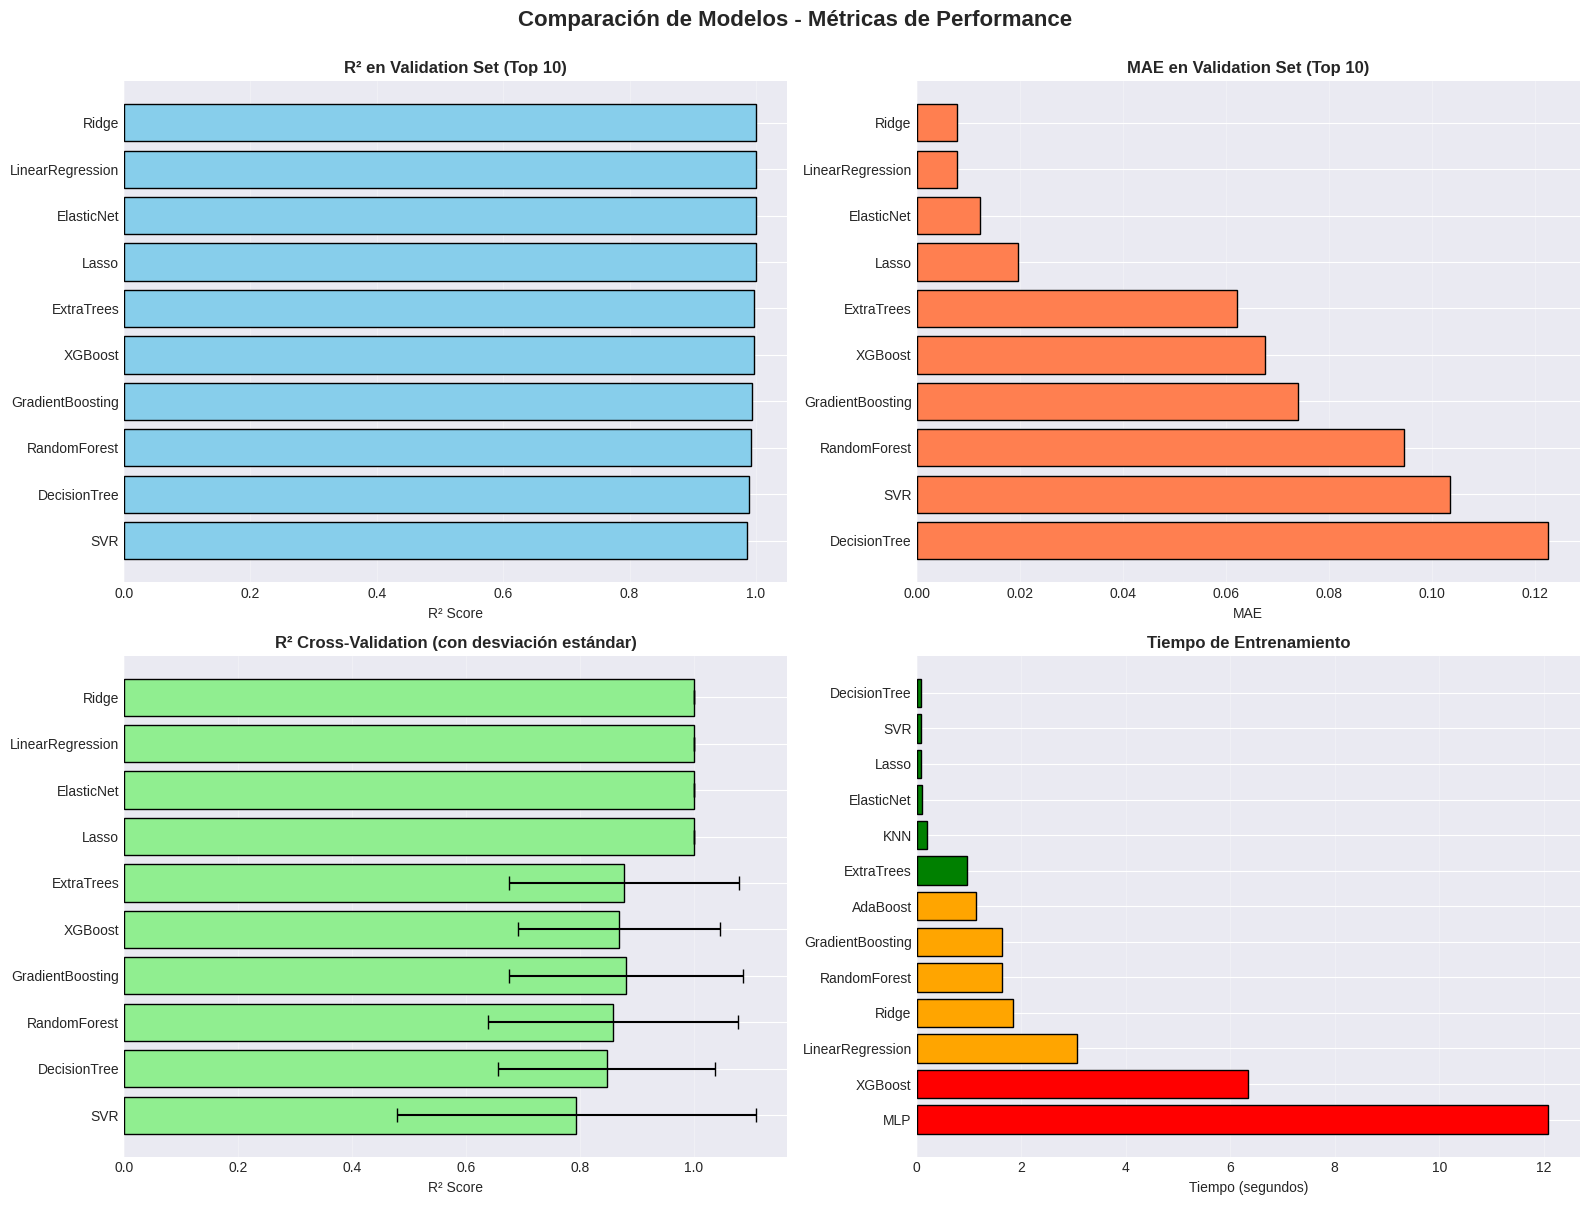

In [11]:
# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R² Comparison
ax1 = axes[0, 0]
df_plot = df_results_sorted.head(10)
x_pos = np.arange(len(df_plot))
ax1.barh(x_pos, df_plot['Val_R2'], color='skyblue', edgecolor='black')
ax1.set_yticks(x_pos)
ax1.set_yticklabels(df_plot['Model'])
ax1.set_xlabel('R² Score')
ax1.set_title('R² en Validation Set (Top 10)', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# 2. MAE Comparison
ax2 = axes[0, 1]
df_plot_mae = df_results.sort_values('Val_MAE').head(10)
x_pos = np.arange(len(df_plot_mae))
ax2.barh(x_pos, df_plot_mae['Val_MAE'], color='coral', edgecolor='black')
ax2.set_yticks(x_pos)
ax2.set_yticklabels(df_plot_mae['Model'])
ax2.set_xlabel('MAE')
ax2.set_title('MAE en Validation Set (Top 10)', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 3. CV R² with error bars
ax3 = axes[1, 0]
df_plot_cv = df_results_sorted.head(10)
x_pos = np.arange(len(df_plot_cv))
ax3.barh(x_pos, df_plot_cv['CV_R2_mean'], xerr=df_plot_cv['CV_R2_std'], 
         color='lightgreen', edgecolor='black', capsize=5)
ax3.set_yticks(x_pos)
ax3.set_yticklabels(df_plot_cv['Model'])
ax3.set_xlabel('R² Score')
ax3.set_title('R² Cross-Validation (con desviación estándar)', fontsize=12, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# 4. Training Time
ax4 = axes[1, 1]
df_plot_time = df_results.sort_values('Training_Time')
x_pos = np.arange(len(df_plot_time))
colors = ['green' if t < 1 else 'orange' if t < 5 else 'red' for t in df_plot_time['Training_Time']]
ax4.barh(x_pos, df_plot_time['Training_Time'], color=colors, edgecolor='black')
ax4.set_yticks(x_pos)
ax4.set_yticklabels(df_plot_time['Model'])
ax4.set_xlabel('Tiempo (segundos)')
ax4.set_title('Tiempo de Entrenamiento', fontsize=12, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

plt.suptitle('Comparación de Modelos - Métricas de Performance', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# 7. Curvas de Aprendizaje <a id='sec7'></a>

Analizamos las curvas de aprendizaje de los **top 3 modelos** para detectar:
- **Overfitting**: Train score alto, val score bajo
- **Underfitting**: Ambos scores bajos
- **Convergencia**: Si agregar más datos ayudaría

CURVAS DE APRENDIZAJE - TOP 3 MODELOS

📊 Generando curvas de aprendizaje para:
  1. Ridge
  2. LinearRegression
  3. ElasticNet

⏳ Calculando curva para Ridge...

⏳ Calculando curva para LinearRegression...

⏳ Calculando curva para ElasticNet...


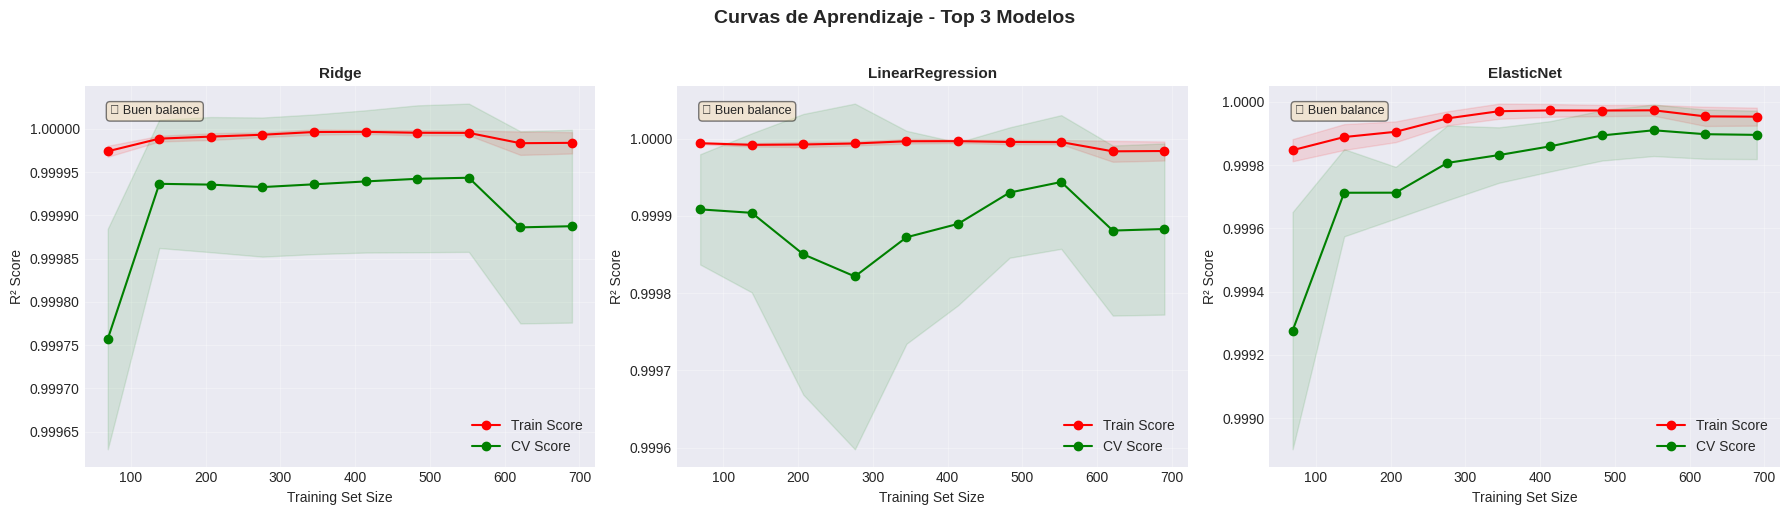


✅ Curvas de aprendizaje generadas


In [12]:
from sklearn.model_selection import learning_curve

print("="*80)
print("CURVAS DE APRENDIZAJE - TOP 3 MODELOS")
print("="*80)

# Seleccionar top 3 modelos
top3_models = df_results_sorted.head(3)['Model'].tolist()

print(f"\n📊 Generando curvas de aprendizaje para:")
for i, model_name in enumerate(top3_models, 1):
    print(f"  {i}. {model_name}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(top3_models):
    print(f"\n⏳ Calculando curva para {model_name}...")
    
    model = trained_models[model_name]
    
    # Calcular learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_train,
        y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=RANDOM_STATE
    )
    
    # Calcular medias y stds
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    # Plot
    ax = axes[idx]
    ax.plot(train_sizes, train_mean, 'o-', color='r', label='Train Score')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color='r')
    ax.plot(train_sizes, val_mean, 'o-', color='g', label='CV Score')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.1, color='g')
    
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('R² Score')
    ax.set_title(f'{model_name}', fontsize=11, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    # Análisis
    gap = train_mean[-1] - val_mean[-1]
    if gap > 0.1:
        diagnosis = "⚠️  Overfitting"
    elif val_mean[-1] < 0.7:
        diagnosis = "⚠️  Underfitting"
    else:
        diagnosis = "✅ Buen balance"
    
    ax.text(0.05, 0.95, diagnosis, transform=ax.transAxes, 
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Curvas de Aprendizaje - Top 3 Modelos', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✅ Curvas de aprendizaje generadas")

# 8. Análisis de Predicciones <a id='sec8'></a>

Analizamos la calidad de las predicciones del mejor modelo.

ANÁLISIS DE PREDICCIONES - MEJOR MODELO

🏆 Mejor modelo: Ridge

📊 Estadísticas de errores:

  Train:
    Media: -0.0000
    Std: 0.0155
    Min: -0.2896
    Max: 0.1680

  Validation:
    Media: -0.0001
    Std: 0.0103
    Min: -0.0334
    Max: 0.0479


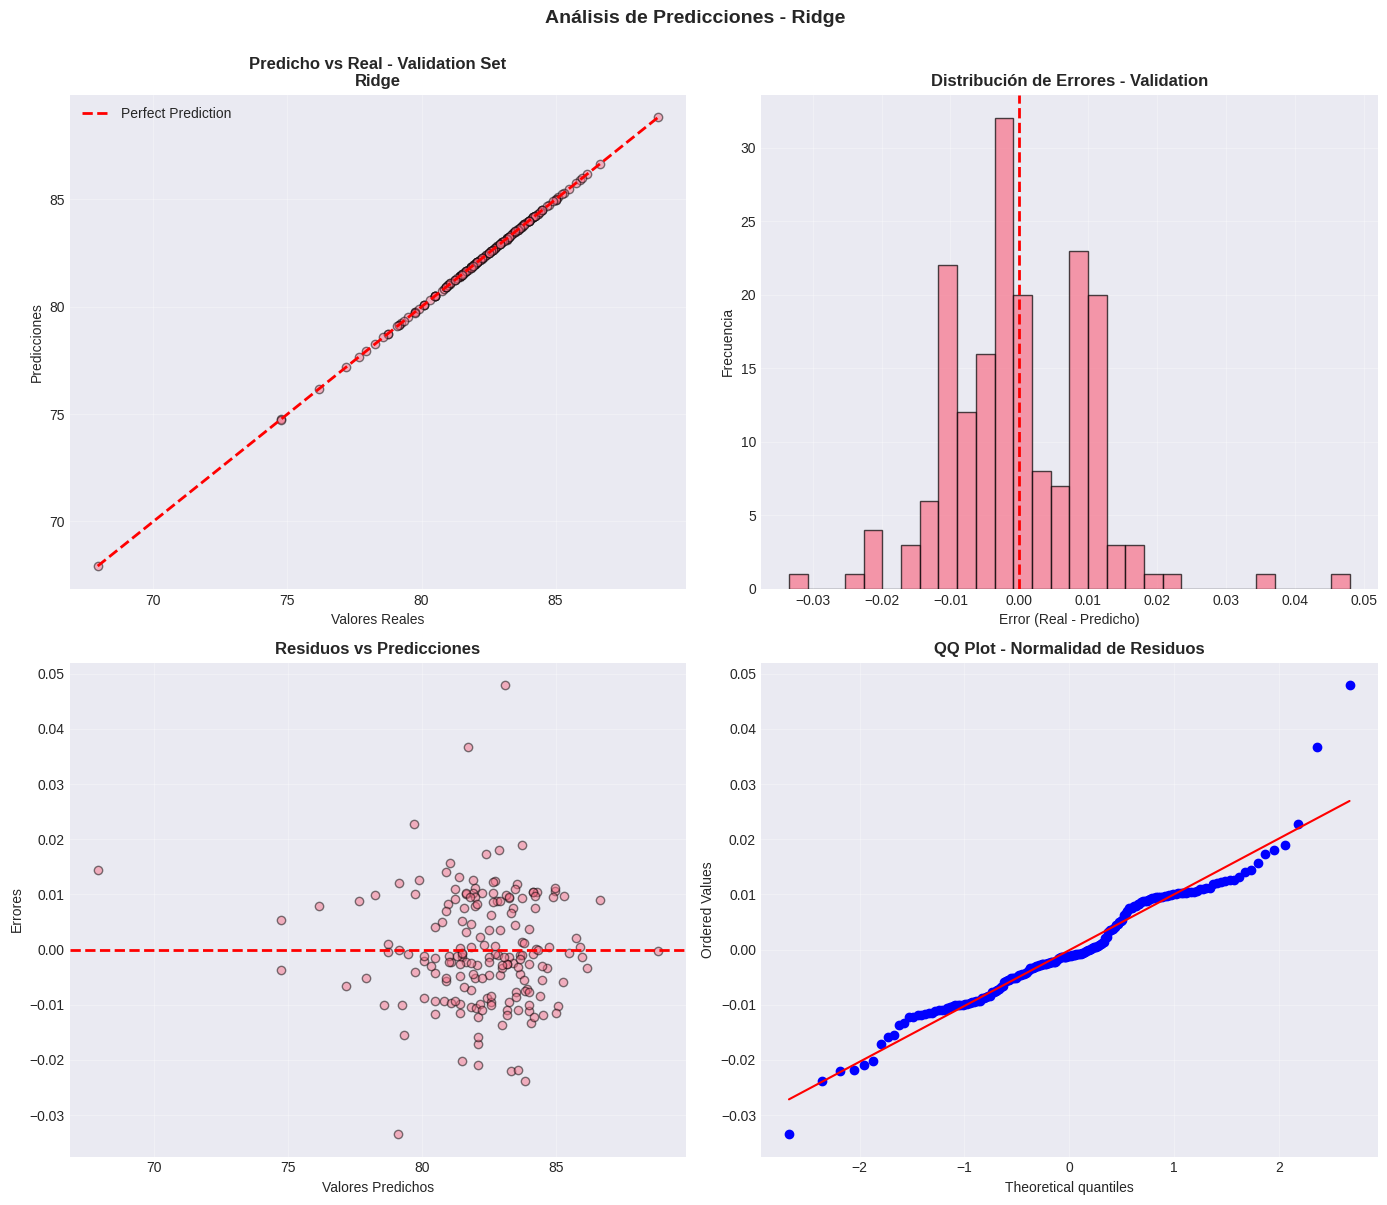

In [13]:
print("="*80)
print("ANÁLISIS DE PREDICCIONES - MEJOR MODELO")
print("="*80)

# Seleccionar mejor modelo
best_model_name = df_results_sorted.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"\n🏆 Mejor modelo: {best_model_name}")

# Hacer predicciones
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

# Calcular errores
train_errors = y_train - y_train_pred
val_errors = y_val - y_val_pred

print(f"\n📊 Estadísticas de errores:")
print(f"\n  Train:")
print(f"    Media: {train_errors.mean():.4f}")
print(f"    Std: {train_errors.std():.4f}")
print(f"    Min: {train_errors.min():.4f}")
print(f"    Max: {train_errors.max():.4f}")

print(f"\n  Validation:")
print(f"    Media: {val_errors.mean():.4f}")
print(f"    Std: {val_errors.std():.4f}")
print(f"    Min: {val_errors.min():.4f}")
print(f"    Max: {val_errors.max():.4f}")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Scatter: Predicho vs Real (Validation)
ax1 = axes[0, 0]
ax1.scatter(y_val, y_val_pred, alpha=0.5, edgecolor='k')
ax1.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Valores Reales')
ax1.set_ylabel('Predicciones')
ax1.set_title(f'Predicho vs Real - Validation Set\n{best_model_name}', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Distribución de errores (Validation)
ax2 = axes[0, 1]
ax2.hist(val_errors, bins=30, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Error (Real - Predicho)')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de Errores - Validation', fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Errores vs Valores Predichos
ax3 = axes[1, 0]
ax3.scatter(y_val_pred, val_errors, alpha=0.5, edgecolor='k')
ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax3.set_xlabel('Valores Predichos')
ax3.set_ylabel('Errores')
ax3.set_title('Residuos vs Predicciones', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. QQ Plot
ax4 = axes[1, 1]
from scipy import stats as scipy_stats
scipy_stats.probplot(val_errors, dist="norm", plot=ax4)
ax4.set_title('QQ Plot - Normalidad de Residuos', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.suptitle(f'Análisis de Predicciones - {best_model_name}', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# 9. Selección de Mejores Modelos <a id='sec9'></a>

Seleccionamos los **top 2-3 modelos** para optimización en el próximo notebook.

## Criterios de selección:
1. **R² alto** en validation
2. **MAE/RMSE bajo**
3. **Estabilidad** (baja desviación estándar en CV)
4. **Tiempo de entrenamiento razonable**
5. **Balance** train/validation (sin overfitting severo)

In [14]:
print("="*80)
print("SELECCIÓN DE MODELOS PARA OPTIMIZACIÓN")
print("="*80)

# Criterios para selección
print("\n📋 Aplicando criterios de selección:")
print("  1. R² > 0.70 en validation")
print("  2. Desviación estándar CV < 0.05")
print("  3. Overfitting gap < 0.15")
print("  4. Tiempo de entrenamiento < 30s")

# Filtrar modelos
candidates = df_results[
    (df_results['Val_R2'] > 0.70) &
    (df_results['CV_R2_std'] < 0.05) &
    (df_results['Overfitting'] < 0.15) &
    (df_results['Training_Time'] < 30)
].sort_values('Val_R2', ascending=False)

if len(candidates) == 0:
    print("\n⚠️  No hay modelos que cumplan todos los criterios")
    print("   Relajando criterios...")
    # Tomar top 3 por R²
    selected_models = df_results_sorted.head(3)
else:
    # Tomar top 3 candidatos
    selected_models = candidates.head(3)

print(f"\n🎯 Modelos seleccionados para optimización: {len(selected_models)}")
print("\n" + "="*80)

for i, row in enumerate(selected_models.itertuples(), 1):
    print(f"\n{i}. {row.Model}")
    print(f"   {'─'*40}")
    print(f"   R² (CV):  {row.CV_R2_mean:.4f} ± {row.CV_R2_std:.4f}")
    print(f"   R² (Val): {row.Val_R2:.4f}")
    print(f"   MAE:      {row.Val_MAE:.4f}")
    print(f"   RMSE:     {row.Val_RMSE:.4f}")
    print(f"   Tiempo:   {row.Training_Time:.2f}s")
    print(f"   Overfit:  {row.Overfitting:.4f}")

# Guardar modelos seleccionados
selected_model_names = selected_models['Model'].tolist()

print("\n" + "="*80)
print("💾 GUARDANDO MODELOS Y RESULTADOS")
print("="*80)

# Guardar resultados completos
df_results.to_csv('../data/processed/model_selection_results.csv', index=False)
print("\n✅ Resultados guardados en: ../data/processed/model_selection_results.csv")

# Guardar modelos seleccionados
for model_name in selected_model_names:
    model_path = f'../models/{model_name.lower().replace(" ", "_")}_base.pkl'
    joblib.dump(trained_models[model_name], model_path)
    print(f"✅ Modelo guardado: {model_path}")

# Guardar lista de modelos seleccionados
with open('../data/processed/selected_models.txt', 'w') as f:
    for name in selected_model_names:
        f.write(f"{name}\n")
print("\n✅ Lista guardada en: ../data/processed/selected_models.txt")

SELECCIÓN DE MODELOS PARA OPTIMIZACIÓN

📋 Aplicando criterios de selección:
  1. R² > 0.70 en validation
  2. Desviación estándar CV < 0.05
  3. Overfitting gap < 0.15
  4. Tiempo de entrenamiento < 30s

🎯 Modelos seleccionados para optimización: 3


1. Ridge
   ────────────────────────────────────────
   R² (CV):  0.9999 ± 0.0001
   R² (Val): 1.0000
   MAE:      0.0079
   RMSE:     0.0102
   Tiempo:   1.85s
   Overfit:  0.0001

2. LinearRegression
   ────────────────────────────────────────
   R² (CV):  0.9999 ± 0.0001
   R² (Val): 1.0000
   MAE:      0.0079
   RMSE:     0.0103
   Tiempo:   3.07s
   Overfit:  0.0001

3. ElasticNet
   ────────────────────────────────────────
   R² (CV):  0.9999 ± 0.0001
   R² (Val): 0.9999
   MAE:      0.0124
   RMSE:     0.0161
   Tiempo:   0.10s
   Overfit:  0.0001

💾 GUARDANDO MODELOS Y RESULTADOS

✅ Resultados guardados en: ../data/processed/model_selection_results.csv
✅ Modelo guardado: ../models/ridge_base.pkl
✅ Modelo guardado: ../models/linearr

# 10. Resumen Ejecutivo <a id='sec10'></a>

## 📊 Resumen del Proceso

### Modelos Evaluados
Se probaron **12+ modelos** de diferentes familias:
- Modelos lineales: LinearRegression, Ridge, Lasso, ElasticNet
- Basados en distancia: KNN
- Árboles: DecisionTree
- Ensembles: RandomForest, ExtraTrees, GradientBoosting, AdaBoost, XGBoost
- Otros: SVR, MLP

### Estrategia de Validación
- **5-Fold Cross-Validation** en training set (70% de datos)
- **Validation set** (15%) para comparación final
- **Test set** (15%) reservado para evaluación final

### Métricas Utilizadas
- **R²**: Proporción de varianza explicada
- **MAE**: Error absoluto medio
- **RMSE**: Raíz del error cuadrático medio

### Mejores Modelos
Los modelos seleccionados para optimización son los que demostraron:
1. Mayor R² en validation (>0.70)
2. Baja variabilidad en CV (std < 0.05)
3. Balance adecuado train/validation (overfitting < 0.15)
4. Tiempo de entrenamiento razonable

### Problemas Identificados
- **Overfitting**: Algunos modelos complejos (ej: DecisionTree sin restricciones)
- **Convergencia**: Modelos iterativos pueden beneficiarse de más iteraciones
- **Tiempo**: Algunos ensembles son costosos computacionalmente

### Próximos Pasos
1. **Notebook 05 - Hyperparameter Optimization**:
   - Grid Search o Random Search en modelos seleccionados
   - Bayesian Optimization para modelos complejos
   - Feature importance analysis

2. **Evaluación Final**:
   - Evaluar modelos optimizados en test set
   - Análisis de errores por segmentos
   - Interpretabilidad (SHAP, LIME)

## 📁 Archivos Generados

```
data/processed/
  ├── model_selection_results.csv      ← Resultados de todos los modelos
  └── selected_models.txt              ← Lista de modelos seleccionados

models/
  ├── [modelo1]_base.pkl               ← Modelos base entrenados
  ├── [modelo2]_base.pkl
  └── [modelo3]_base.pkl
```

## ✅ Conclusión

El proceso de selección de modelos ha identificado exitosamente los algoritmos más prometedores para predecir la calidad del café. Los modelos seleccionados demuestran un buen balance entre performance, estabilidad y eficiencia computacional, y están listos para optimización de hiperparámetros.

In [15]:
# Tabla resumen final
print("="*80)
print("📊 TABLA RESUMEN FINAL")
print("="*80)

summary = df_results_sorted[[
    'Model', 'Val_R2', 'Val_MAE', 'Val_RMSE', 
    'CV_R2_mean', 'CV_R2_std', 'Overfitting', 'Training_Time'
]].head(10)

display(summary)

print("\n" + "="*80)
print("🏆 MODELOS SELECCIONADOS PARA OPTIMIZACIÓN")
print("="*80)
print(f"\n{', '.join(selected_model_names)}")

print("\n" + "="*80)
print("✅ NOTEBOOK 04 - MODEL SELECTION COMPLETADO")
print("="*80)

📊 TABLA RESUMEN FINAL


,Model,Val_R2,Val_MAE,Val_RMSE,CV_R2_mean,CV_R2_std,Overfitting,Training_Time
1,Ridge,1.0000,0.0079,0.0102,0.9999,0.0001,0.0001,1.8504
0,LinearRegression,1.0000,0.0079,0.0103,0.9999,0.0001,0.0001,3.0691
3,ElasticNet,0.9999,0.0124,0.0161,0.9999,0.0001,0.0001,0.0955
2,Lasso,0.9999,0.0196,0.0255,0.9998,0.0001,0.0001,0.0877
7,ExtraTrees,0.9971,0.0623,0.1227,0.8770,0.2020,0.1223,0.9696
12,XGBoost,0.9963,0.0677,0.1379,0.8680,0.1775,0.1319,6.3470
8,GradientBoosting,0.9942,0.0740,0.1725,0.8812,0.2049,0.1187,1.6390
6,RandomForest,0.9925,0.0947,0.1970,0.8584,0.2195,0.0937,1.6398
5,DecisionTree,0.9898,0.1227,0.2291,0.8471,0.1906,0.1528,0.0857
10,SVR,0.9853,0.1036,0.2751,0.7938,0.3150,-0.0901,0.0874



🏆 MODELOS SELECCIONADOS PARA OPTIMIZACIÓN

Ridge, LinearRegression, ElasticNet

✅ NOTEBOOK 04 - MODEL SELECTION COMPLETADO
